<a href="https://colab.research.google.com/github/restinghouse0203/Academic_Project/blob/main/Simluation/ORIE5580_Cornell/script/HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ORIE 4580/5580/5581 Assignment 6

#### Students: Yik Hau Au (ya293) and Dionisius Davido Tjajono (Dt565)

### Github link: [Github link](https://github.com/restinghouse0203/Academic_Project/blob/main/Simluation/ORIE5580_Cornell/script/HW6.ipynb)


### Instructions


* Due Thursday, November 20, at 11.59pm on Gradescope.
* Assignment .ipynb files available for download on Canvas. Do all your work in provided notebook (text answers typeset in markdown; show all required code and generate plots inline), and then generate and submit a pdf.
* Do all your work in provided notebook (text answers typeset in markdown; show all required code and generate plots inline), and then generate and submit a pdf.
* Ideally do assignments in groups of 2, and submit a single pdf with both names
* Please show your work and clearly mark your answers.
* You can use any code fragments given in class, found online (for example, on StackOverflow), or generated via Gemini/Claude/ChatGPT (you are encouraged to use these for first drafts) **with proper referencing**.
* You can also discuss with others (again, please reference them if you do so); but you must write your final answers on your own as a team.



### Essential reading

The chapters on [Poisson Process](https://canvas.cornell.edu/courses/80773/modules/items/3269525), [DTMCs](https://canvas.cornell.edu/courses/80773/modules/items/3426077) and [CTMCs](https://canvas.cornell.edu/courses/80773/modules/items/3426086) from Mor Harchol-Balter, posted on Canvas

In [41]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
import heapq
import math

<hr><hr>

# Question 1 (The Spotify Shuffle)

**(a)** (10 pts) You have a Spotify playlist with $n$ songs playing on shuffle. Suppose Spotify truly picks a random song each time -- you want to see how many songs it takes on average to play **every song** on your playlist. Build a simulator to estimate this for a different values of $n$, and use this to try and guess the function.

*Note 1*: We saw this in class as the `coupon collector' problem -- we also saw a way to compute the exact expected time in an earlier clicker question...

*Note 2*: Try and pick a large range of $n$ to get a sense of the function, and also make sure you always show your CIs!


<hr>

## Ans.

In [42]:
def uni_song_pick_time_count(n):
    t = 0
    song_list = list(range(n))  # List of songs 0 to n-1
    uni = set()  # Initialize an empty set to track unique songs
    while len(uni) < n:
        new_song = random.choice(song_list)
        uni.add(new_song)  # Add to set (automatically handles uniqueness)
        t += 1
    return t

In [43]:
np.random.seed(42)
S = 1000
N = range(50, 500, 50)
avg_time_spent = []
LB_CI = []
UB_CI = []

for n in N:
  t = []
  for _ in range(S):
    t.append(uni_song_pick_time_count(n))

  mean_time = np.mean(t)
  se = np.std(t,ddof=1)
  avg_time_spent.append(mean_time)
  LB_CI.append(mean_time-1.96*se/np.sqrt(S))
  UB_CI.append(mean_time+1.96*se/np.sqrt(S))

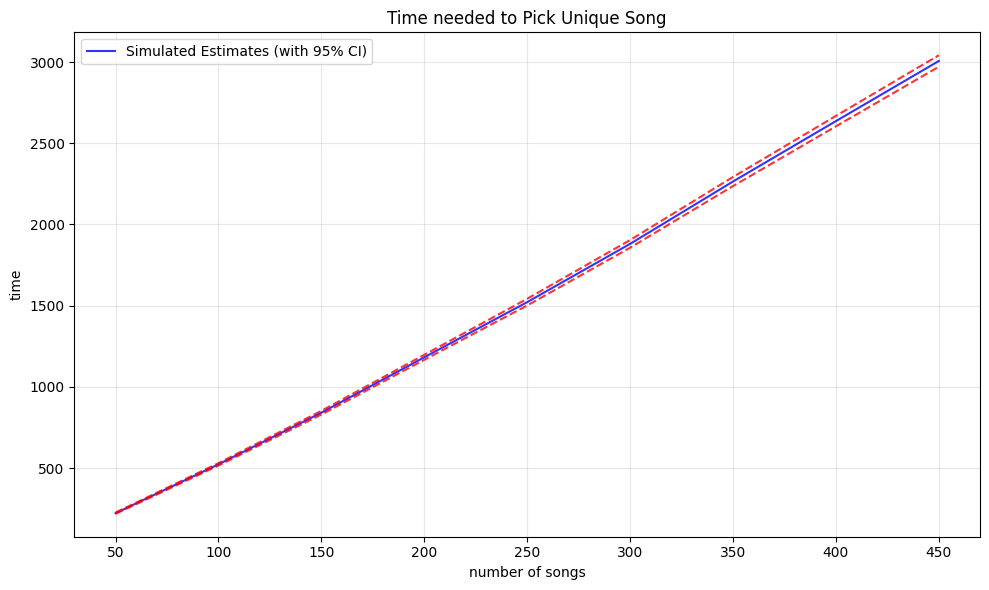

In [44]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(N, avg_time_spent, color='blue', label='Simulated Estimates (with 95% CI)', alpha=0.8)
plt.plot(N, LB_CI, color='red', ls='--', alpha=0.8)
plt.plot(N, UB_CI, color='red', ls='--', alpha=0.8)
plt.title('Time needed to Pick Unique Song')
plt.xlabel('number of songs')
plt.ylabel('time')
plt.grid(True, alpha=0.3)
plt.xticks(N)
plt.legend()
plt.tight_layout()
plt.show()

<hr>

**(b)** (10 pts) Suppose Spotify uses the following poor randomizer: it labels songs as $\{0,1,2,\ldots,n-1\}$, and after playing a song $i$, it then either plays song $(i+1) mod(n)$ or $(i-1)mod(n)$ with probability $1/2$ (i.e., the next or previous song, imagining the songs to be in a ring with $n-1$ wrapping around to $1$). Simulate this randomizer for $n=20$, assuming you always start at song $1$, and find the histogram of the *last song to be played* for the first time using this shuffler.   


<hr>

## Ans.

In [45]:
def simulate_last_song(n, start_song=1):
    seen = set([start_song])  # Start with song 1 visited
    current = start_song
    while len(seen) < n:
        direction = random.choice([-1, 1])
        next_song = (current + direction) % n
        # If this is a new song, add it and check if it's the last one
        if next_song not in seen:
            seen.add(next_song)
            if len(seen) == n:  # This is the last unique song
                return next_song
        current = next_song

In [46]:
np.random.seed(42)
S = 10000
n = 20
last_songs = []

for _ in range(S):
    last_songs.append(simulate_last_song(n))

mean_time = np.mean(t)
avg_time_spent.append(mean_time)

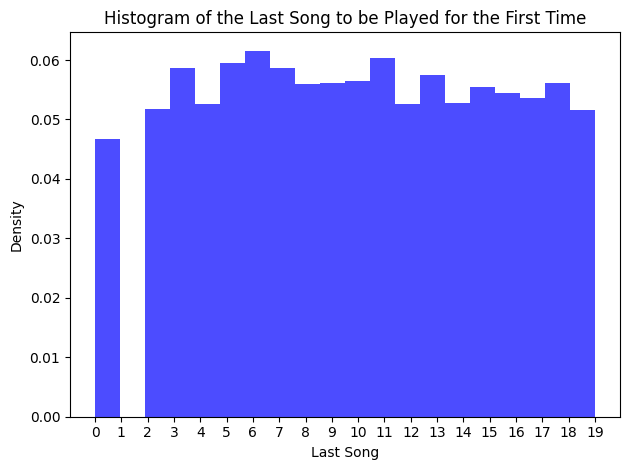

In [47]:
# Plot histogram of the last songs (density=True for probability density)
plt.hist(last_songs, bins=n, density=True, alpha=0.7, color='blue')
plt.title('Histogram of the Last Song to be Played for the First Time')
plt.xlabel('Last Song')
plt.ylabel('Density')
plt.xticks(range(n))
plt.tight_layout()
plt.show()

<hr><hr>

# Question 2 (The Gambler's Ruin)


In class, we saw the balanced gambler's ruin problem: two gambler's $A$ and $B$ start with $\$a$ and $\$b$ initially, and play a sequence of games, where each game is won by either player with probability $1/2$, with the winner giving $\$ 1$ to the loser. Play goes on till one player runs out of money.

<hr>

**(a)** (5 pts) We argued that when both players have the same initial budget, then each player is equally likely to win. We now want to run a simulation to find a similar formula for general initial budgets. To do so, assume the total budget is $a+b=20$, and run simulations to find the expected probability that $A$ wins for all values of $a$ from $\{0,1,\ldots,20\}$. Plot these, and use this to conjecture what the formula may be.


<hr>

## Ans.

In [48]:
def gambler_ruin(a,M):
  while a>0 and a < M:
    a+=random.choice([1,-1])
  if a==0:
    return 0
  if a==M:
    return 1

In [49]:
np.random.seed(42)
S = 10000
M = 20
A = range(21)
avg_win_rate = []
LB_CI = []
UB_CI = []

for a in A:
  result_per_a = []
  for _ in range(S):
    result_per_a.append(gambler_ruin(a,M))
  expected_win_prob = np.sum(result_per_a)/S
  avg_win_rate.append(expected_win_prob)
  se = np.sqrt(expected_win_prob*(1-expected_win_prob)/S)
  LB_CI.append(expected_win_prob-1.96*se)
  UB_CI.append(expected_win_prob+1.96*se)

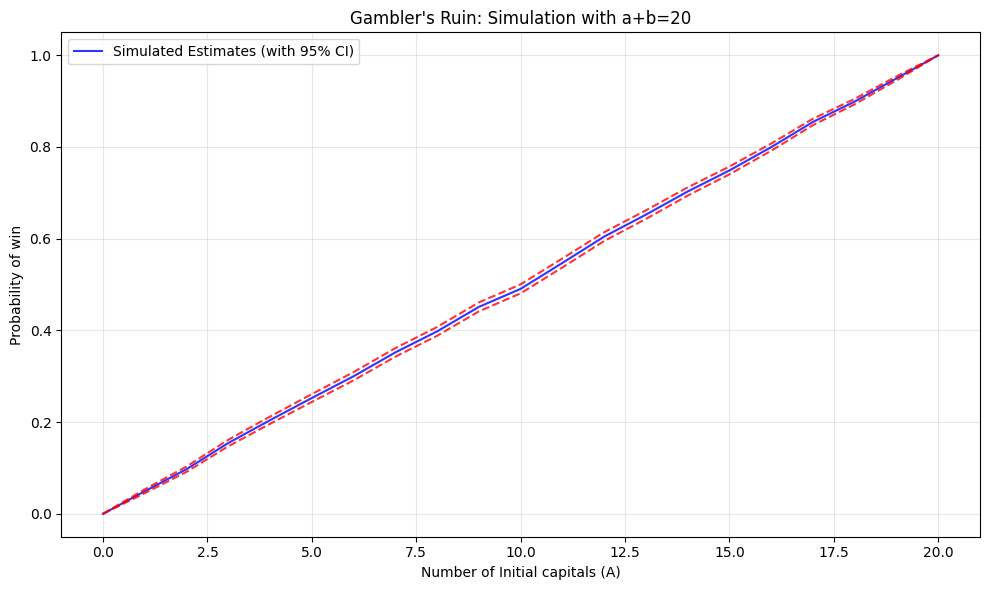

In [50]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(A, avg_win_rate, color='blue', label='Simulated Estimates (with 95% CI)', alpha=0.8)
plt.plot(A, LB_CI, color='red', ls='--', alpha=0.8)
plt.plot(A, UB_CI, color='red', ls='--', alpha=0.8)
plt.title('Gambler\'s Ruin: Simulation with a+b=20')
plt.xlabel('Number of Initial capitals (A)')
plt.ylabel('Probability of win')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

conjecture:

**(b)** (10 pts) Another question we can ask is how long it takes for either player to get ruined. To study this, simulate the gambler's ruin for a range of values of $a$ and $b$, and use this to try and guess the expected time to ruin.

Note: Convince yourself that the function must be symmetric in $a$ and $b$, so you can assume $a\leq b$. Try plotting the expected absorption times for selected values of $a$, while varying $b$.


<hr>

## Ans.

In [51]:
def gambler_ruin_ab(a,b):
  t = 0
  M = a+b
  while a>0 and a<M and b>0 and b<M:
    outcome = random.choice([1,-1]) # outcome of a win or lose in this round
    a += outcome
    b -= outcome
    t+=1
  if a==0 or b == M:
    return t # a lose
  if a==M or b == 0:
    return t # a win

In [52]:
np.random.seed(42)
S = 10000
M = 100
A = 10
B = range(A,100)
expected_abs_time = []
LB_CI = []
UB_CI = []

for b in B:
  ruin_time = []
  for _ in range(S):
    ruin_time.append(gambler_ruin_ab(a,b))
  mean_time = np.mean(ruin_time)
  se = np.std(ruin_time, ddof=1) / np.sqrt(S)  # Standard error of the mean
  expected_abs_time.append(mean_time)
  LB_CI.append(mean_time - 1.96 * se)
  UB_CI.append(mean_time + 1.96 * se)

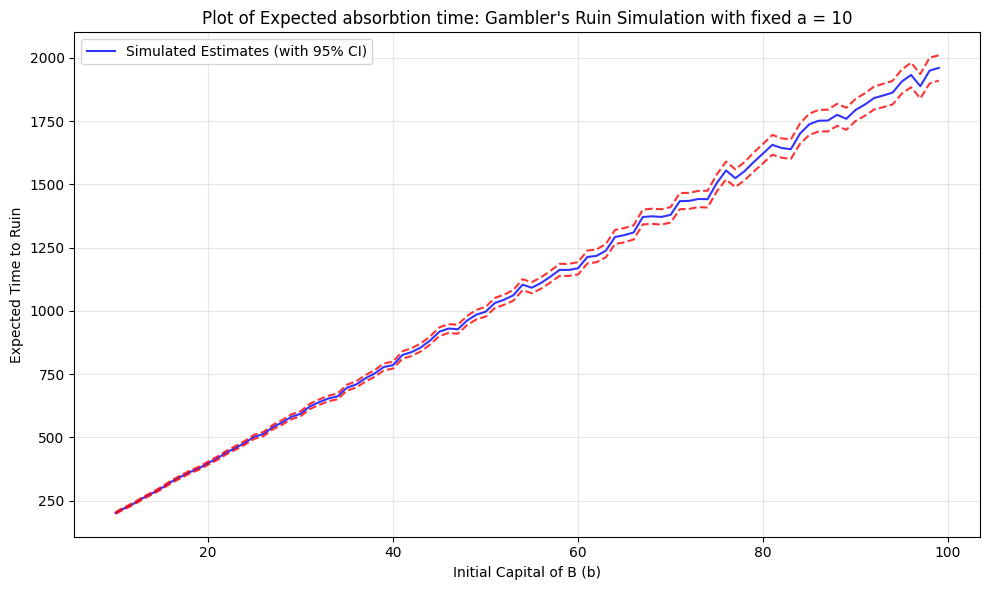

In [53]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(B, expected_abs_time, color='blue', label='Simulated Estimates (with 95% CI)', alpha=0.8)
plt.plot(B, LB_CI, color='red', ls='--', alpha=0.8)
plt.plot(B, UB_CI, color='red', ls='--', alpha=0.8)
plt.title('Plot of Expected absorbtion time: Gambler\'s Ruin Simulation with fixed a = 10')
plt.xlabel('Initial Capital of B (b)')
plt.ylabel('Expected Time to Ruin')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

<hr>

**(c)** (OPTIONAL) For parts $(a)$ and $(b)$, try and theoretically prove what you observe from your simulations!


<hr>

## Ans.

Part A,\
Let $p_n$ be the probability that A wins starting from capital n (where $0 \leq n \leq M = a+b$). The boundary conditions are:
$$
p_0 = 0, \text{ A is ruined.} \\
p_M = 1, \text{ B is ruined.}
$$

For 0 < n < M, the recurrence is:
$$
p_n = \frac{1}{2} p_{n+1} + \frac{1}{2} p_{n-1}
$$

Rearranging gives:
$$
p_{n+1} - p_n = p_n - p_{n-1} := d \text{ (constant)}
$$

$$
p_n = p_0 + n \cdot d = n \cdot d
$$

Using the boundary $p_M$ = 1:
$$
M \cdot d = 1 \implies d = \frac{1}{M} \implies p_n = \frac{n}{M}
$$

Thus, starting from captial a , $P(\text{A wins}) = \frac{a}{M} = \frac{a}{a+b}.$


Part b,\
Let $e_n$ be the expected time to absorption starting from capital n, where $0 \leq n \leq M=a+b$. The boundary conditions (absorption state) are:
$$
e_0 = 0 .
e_M = 0 .
$$
For 0 < n < M, the recurrence is:
$$
e_n = 1 + 0.5 e_{n-1} + 0.5 e_{n+1}, \quad n = 1, 2, \dots, M-1
$$
with boundary conditions $e_0 = 0$ and $e_M = 0$.

\begin{equation}
e_{n-1} - 2e_n + e_{n+1} = -2
\end{equation}

First, solve the homogeneous part:
$$
e_{n-1} - 2e_n + e_{n+1} = 0
$$
The characteristic equation is:
$$
r^2 - 2r + 1 = 0 \implies (r-1)^2 = 0
$$
This has a repeated root r = 1, so the homogeneous solution is:
$$
e_n = (A + B n)
$$
For some constant A,B.

For the non-homogeneous term (constant on the right-hand side, $-2$), try $e_n = C n^2$ (quadratic, due to the repeated root).

We obtain, $e_{n-1} - 2e_n + e_{n+1} = -2$:
$$
C(n-1)^2 - 2C n^2 + C(n+1)^2 = -2
$$

Expand:
\begin{align*}
&C(n^2 - 2n + 1) - 2C n^2 + C(n^2 + 2n + 1) \\
&= C n^2 - 2C n + C - 2C n^2 + C n^2 + 2C n + C = 2C = -2
\end{align*}
So, C = -1, and $e_n = -n^2$.

Combine homogeneous and particular solutions:
$$
e_n = A + B n - n^2
$$

Apply Boundary Conditions
- $e_0 = 0: A + B \cdot 0 - 0^2 = 0 \implies A = 0$
- $e_M = 0: 0 + B M - M^2 = 0 \implies B M = M^2 \implies B = M$

Thus, the exact solution is:
$$
e_n = M n - n^2 = n (M - n)
$$

<hr><hr>

# Question 3 (Staffing a hospital)


Consider the model of the Fingerlakes Regional Hospital as shown below. New patients arrive at the reception at a rate of 20/hr and emergency patients enter the ER at a rate of 5/hr. The reception desk for non-emergency patients is managed by $n_R$ associates. Admission at the reception (not counting any queueing time) takes 5 minutes on average, regardless of whether the non-emergency patient is first-time or returning. The clinic is served by $d_C$ doctors with an average visit time of 15 minutes. About one in every four patients visiting the clinic are asked to return for a follow-up appointment that is, on average, 3 weeks (504 hours) later in time; another one-tenth of visitors to the clinic are referred to the internal ward (IW); the rest are treated and discharged. Patients arriving to the ER require about 1 hour of time with a doctor. The ER is staffed by $d_E$ doctors. Half of the patients in the ER are discharged after treatment, with the remainder referred to the IW. The average stay in the IW is about 72 hours and there are $n_I$ IW beds available. After a stay at the IW, 20\% of patients are discharged, whereas the rest are asked to return for a follow-up appointment as a non-emergency patient that is, on average, 3 weeks (504 hours) later in time. The reception, clinic, ER and IW all have their separate waiting areas and wait-lists, and serve patients on a FCFS basis.


![](https://github.com/restinghouse0203/Academic_Project/blob/main/Simluation/ORIE5580_Cornell/script/hwq2figure.png?raw=1)

**(a)** (5 pts)  Find bounds on the number of receptionists $n_R$, IW beds $N_I$, clinic doctors $d_C$ and ER doctors $d_E$ that the hospital requires to ensure it can keep up with its patient load?

<hr>

## Ans.

Define $λ_R$ be the rate of arrival at reception, $λ_E$ be the rate of arrival at ER, $λ_I$ be the rate of arrival at IW, we have
$$
λ_R = 20 + 0.25λ_R + 0.8λ_I \\
λ_I=0.1λ_R+0.5λ_E \\
\Rightarrow λ_R=32.84, λ_I=5.784
$$
Set the work capcity be strict greater than the work load arrival. \
At reception, $n_R\geq\lceil32.84/12\rceil=3$ \
At clinic, $d_c\geq\lceil32.84/4\rceil=9$ \
At IW, $N_I\geq\lceil5.784*72\rceil=417$ \
At ER, $d_R\geq\lceil5/1\rceil=5$

<hr>

**(b)** (10 pts) Suppose the hospital chooses to run with $d_E=7$ doctors in the ER, $d_C=10$ doctors in the clinic, and $n=500$ beds in the IW. Approximate the average time spent in the clinic (including treatment but not including reception) and the average number of busy clinic doctors.

<hr>

## Ans.

In [54]:
np.random.seed(42)

import random
import math

def simulate_mm_c_stats(lambda_rate, mu_rate, c, T_max=1_000_000):
    t = 0.0
    n = 0  # number in system
    area_n = 0.0
    area_busy = 0.0
    last_t = 0.0

    while t < T_max:
        rate_depart = min(n, c) * mu_rate
        rate_total = lambda_rate + rate_depart
        if rate_total == 0.0:
            break

        # next event time
        dt = -math.log(1.0 - random.random()) / rate_total
        if t + dt > T_max:
            dt = T_max - t

        # accumulate time-averages over [t, t+dt)
        area_n += n * dt
        area_busy += min(n, c) * dt

        t += dt
        if t >= T_max:
            break

        # arrival or departure
        if random.random() < lambda_rate / rate_total:
            n += 1   # arrival
        else:
            if n > 0:
                n -= 1  # departure

    L = area_n / T_max
    busy_avg = area_busy / T_max
    W = L / lambda_rate
    return L, W, busy_avg

In [55]:
lambda_C = 32.84
mu_C = 4.0
D_C = 10

L_C, W_C, busy_C = simulate_mm_c_stats(lambda_C, mu_C, D_C)

In [56]:
print(f"Simulated avg time in clinic W ≈ {W_C:.4f} hours")
print(f"Simulated avg busy clinic doctors ≈ {busy_C:.4f}")

Simulated avg time in clinic W ≈ 0.3141 hours
Simulated avg busy clinic doctors ≈ 8.2134


<hr>

**(c)** (10 pts) Suppose the hospital chooses to run with $d_E=7$ doctors in the ER, $d_C=10$ doctors in the clinic, and $n=500$ beds in the IW. Compute the probability that the hospital will simultaneously have no patients in the ER and no patients in the clinic.

<hr>

## Ans.

In [57]:
import random
import math

def simulate_mm_c(lambda_rate, mu_rate, c, T_max=1_000_000):
    t = 0.0          # current time
    n = 0            # number in system
    time_empty = 0.0

    while t < T_max:
        # current total event rate
        rate_depart = min(n, c) * mu_rate
        rate_total = lambda_rate + rate_depart

        if rate_total == 0.0:
            break  # no events possible

        # time to next event
        dt = -math.log(1.0 - random.random()) / rate_total

        # if next event goes beyond horizon, just account remaining empty time
        if t + dt > T_max:
            if n == 0:
                time_empty += T_max - t
            break

        # accumulate time spent empty
        if n == 0:
            time_empty += dt

        # advance time
        t += dt

        # decide event type: arrival vs departure
        if random.random() < lambda_rate / rate_total:
            # arrival
            n += 1
        else:
            # departure (only if there is someone)
            if n > 0:
                n -= 1

    return time_empty / T_max

In [58]:
# ER: λ = 5, μ = 1, c = 7
P_ER0 = simulate_mm_c(lambda_rate=5.0, mu_rate=1.0, c=7, T_max=1_000_000)

# Clinic: λ = 32.84, μ = 4, c = 10
P_CL0 = simulate_mm_c(lambda_rate=32.84, mu_rate=4.0, c=10, T_max=1_000_000)

In [59]:
print(f"P_ER0 = {P_ER0:.8f}")
print(f"P_CL0 = {P_CL0:.8f}")
print(f"Joint prob = {P_ER0 * P_CL0:.8f}")

P_ER0 = 0.00597135
P_CL0 = 0.00021577
Joint prob = 0.00000129


<hr>

**(d)** (40 pts) Build a simulator for the above model, assuming the external arrivals to the reception and ER are Poisson processes, and all service times are exponential and all routings are independent. You can re-use any of the code we provided in the recitations.

Use your simulator to study the following:

$(i)$ Plot the total number of patients waiting in the hospital when the number of doctors and beds is $1$ more than your suggestions in part $(a)$, and when it is $1$ less than your suggestions in part $(a)$. You should simulate over a long enough time horizon to be able to determine whether the numbers stabilize, or grow unbounded.

$(ii)$ Simulate the configuration in part $(b)$, and plot the average time spent by patients in the clinic, and the average number of busy clinic doctors. How do these compare to the answers in part $(b)$?

<hr>

## Ans.

In [60]:
# General class for the entities that move through the Queues
class Entity(object):

    starttime = 0

    # Initialize an Entity
    def __init__(self, start):
        self.starttime = start

    # Print an Entity (just arrival time)
    def __repr__(self):
        return str(self.starttime)

In [61]:
# General class for the queues themselves
class Queue(object):

    name = ""
    waitingentities = deque() # Initialize as a deque

    # Initialize a Queue
    def __init__(self, name, waiting):
        self.name = name
        self.waitingentities = deque(waiting) # Initialize as a deque

    # Print a Queue (just its name and the entire list of waiting Entities)
    def __repr__(self):
        return self.name + ": " + str(list(self.waitingentities))

    # A new Entity is created and arrives at this Queue
    def ArriveatQueue(self, time):
        newarrival = Entity(time)
        self.waitingentities.append(newarrival) # Use deque.append

    # Exit the Queue (and the system)
    def LeaveQueue(self):
        if len(self.waitingentities) > 0:
            self.waitingentities.popleft() # Use deque.popleft

    #################Send the first Entity in line to another Queue ###########################
    def SendTo(self, destination):
        # Send the second customer (index 1) to the destination queue
        if len(self.waitingentities) > 1:
            entity_to_send = self.waitingentities[1]
            destination.waitingentities.append(entity_to_send)
            del self.waitingentities[1] # Remove the sent entity from the current queue

In [62]:
def arrival(idx, currenttime):
  # This is an event that a customer arrives
  print("A customer arrives at " + station_name[idx])
  nexteventtimes[idx] += np.random.exponential(lambda_rate[idx])
  queue_obj[idx].ArriveatQueue(currenttime)
  if nexteventtimes[idx+4] == 1e6:
      # if the cashier is idle, start the service
      nexteventtimes[idx+4] = currenttime + np.random.exponential(mu_time[idx])

In [63]:
def departure(idx, currenttime):
  print("Customer leave at " + station_name[idx])
  totalwaits.append(currenttime - queue_obj[idx].waitingentities[0].starttime)
  queue_obj[idx].LeaveQueue()

In [64]:
class Entity(object):
    def __init__(self, start):
        self.starttime = start
    def __repr__(self):
        return str(self.starttime)

class Queue(object):
    def __init__(self, name, waiting=None):
        self.name = name
        self.waitingentities = deque(waiting if waiting is not None else [])
    def __repr__(self):
        return self.name + ": " + str(list(self.waitingentities))
    def ArriveatQueue(self, time):
        newarrival = Entity(time)
        self.waitingentities.append(newarrival)
    def LeaveQueue(self):
        if len(self.waitingentities) > 0:
            self.waitingentities.popleft()

In [65]:
# ---------- Arrival & Departure events ----------

def arrival(idx, currenttime):
    # External arrival at station idx
    # schedule next external arrival
    if lambda_rate[idx] > 0:
        nexteventtimes[idx] = currenttime + np.random.exponential(1.0 / lambda_rate[idx])
    # add entity to queue
    queue_obj[idx].ArriveatQueue(currenttime)
    # if server idle, start service
    start_service(idx, currenttime)

def departure(idx, currenttime):
    # departure from station idx
    q = queue_obj[idx]
    if len(q.waitingentities) == 0:
        # safety: no one to serve, make server idle
        nexteventtimes[4 + idx] = 1e6
        return

    entity = q.waitingentities[0]
    # record wait for clinic only (for part (d)(ii))
    if idx == 1:
        totalwaits_clinic.append(currenttime - entity.starttime)

    q.LeaveQueue()

    # route the departing patient
    if idx == 0:
        # from Reception -> always to Clinic
        queue_obj[1].ArriveatQueue(currenttime)
        start_service(1, currenttime)
    else:
        prob = send_off_prob.get(idx, None)
        if prob is not None:
            dest = np.random.choice(range(5), p=prob)
            if dest != 4:  # not going home
                queue_obj[dest].ArriveatQueue(currenttime)
                start_service(dest, currenttime)

    # schedule next service at this station (if someone still waiting)
    if len(q.waitingentities) > 0:
        nexteventtimes[4 + idx] = currenttime + np.random.exponential(mu_time[idx])
    else:
        nexteventtimes[4 + idx] = 1e6


In [66]:
np.random.seed(42)

times = []
Q_len = [[], [], [], []]   # lengths of R, C, ER, IW over time
totalwaits_clinic = []     # to compute avg time in clinic in (d)(ii)
busy_clinic = []           # busy/idle flag for clinic server over time

line_R  = Queue("Line Reception")
line_C  = Queue("Line Clinic")
line_ER = Queue("Line ER")
line_IW = Queue("Line IW")
queue_obj = [line_R, line_C, line_ER, line_IW]

station_name = ["Reception", "Clinic", "ER", "IW"]

# External arrival rates (per hour)
lambda_rate = [32.84, 0.0, 5.0, 0.0]   # only Reception and ER have external arrivals

# Mean service times (hours)
mu_time = [5/60, 15/60, 1.0, 72.0]     # mean service times, not rates

# Routings: prob to R, C, ER, IW, home
# index 0 unused (reception goes deterministically to clinic)
send_off_prob = {
    1: [0.25, 0.0, 0.0, 0.10, 0.65],   # from Clinic
    2: [0.0, 0.0, 0.0, 0.50, 0.50],    # from ER
    3: [0.80, 0.0, 0.0, 0.0, 0.20]     # from IW
}

# ---------- Event times ----------
# indices: 0..3 arrivals, 4..7 departures

# external first arrivals (only R and ER)
nextarrival = [
    np.random.exponential(1.0 / lambda_rate[0]),  # R
    1e6,                                          # C (no external arrivals)
    np.random.exponential(1.0 / lambda_rate[2]),  # ER
    1e6                                           # IW (no external arrivals)
]

nextdeparture = [1e6, 1e6, 1e6, 1e6]

nexteventtimes = np.array(nextarrival + nextdeparture, dtype=float)

# ---------- Helper: (re)start service if idle and queue nonempty ----------

def start_service(idx, currenttime):
    """Start service at station idx if server idle and someone is waiting."""
    dep_index = 4 + idx
    if nexteventtimes[dep_index] == 1e6 and len(queue_obj[idx].waitingentities) > 0:
        nexteventtimes[dep_index] = currenttime + np.random.exponential(mu_time[idx])


# ---------- Main simulation loop ----------

terminal_time = 1000.0  # increase a lot for part (d)(i),(ii)
currenttime = 0.0

while currenttime < terminal_time:
    eventtype = np.argmin(nexteventtimes)
    currenttime = nexteventtimes[eventtype]
    if currenttime >= terminal_time:
        break

    if eventtype <= 3:          # arrival
        arrival(eventtype, currenttime)
    else:                       # departure
        idx = eventtype - 4
        departure(idx, currenttime)

    # record queue lengths and busy/idle for clinic
    times.append(currenttime)
    for i, line in enumerate(queue_obj):
        Q_len[i].append(len(line.waitingentities))
    # busy clinic doctor: 1 if departure scheduled (server busy), else 0
    busy_clinic.append(1 if nexteventtimes[5] < 1e6 else 0)

In [67]:
avg_time_clinic = np.mean(totalwaits_clinic) if totalwaits_clinic else 0.0
avg_busy_clinic = np.mean(busy_clinic) if busy_clinic else 0.0

print(f"Simulated avg time in clinic ≈ {avg_time_clinic:.4f} hours "
      f"({avg_time_clinic*60:.2f} minutes)")
print(f"Simulated avg number of busy clinic doctors (with 1 server here) ≈ "
      f"{avg_busy_clinic:.4f}")
print(f"Simulated avg number in clinic queue ≈ {np.mean(Q_len[1]):.4f}")

Simulated avg time in clinic ≈ 338.4842 hours (20309.05 minutes)
Simulated avg number of busy clinic doctors (with 1 server here) ≈ 0.9999
Simulated avg number in clinic queue ≈ 4149.4320


In [68]:
# old code
# np.random.seed(42)
# # Store data for plot (you can store whatever data you like in lists like this)
# times = []
# Q_len = [[],[],[],[]]
# qR_len = []
# qC_len = []
# qER_len = []
# qIW_len = []
# totalwaits = []

# # Create queues (you will need to create a Queue for every station in the clinic)
# line_R = Queue("Line Reception", [])
# line_C = Queue("Line Clinic", [])
# line_ER = Queue("Line ER", [])
# line_IW = Queue("Line IW", [])
# queue_obj = [line_R, line_C, line_ER, line_IW]

# # General discrete-event loop
# # Name
# station_name = ["Reception", "Clinic", "ER", "IW"]

# # Initialize times
# lambda_rate = [32.84, 32.84, 5, 5.784] #lambda_R, lambda_C, lambda_ER, lambda_IW,

# # Average Service Times (hours)
# mu_time = [5/60,15/60,1,72] #mu_R, mu_C, mu_ER, mu_IW

# currenttime = 0
# nextarrival = [np.random.exponential(lambda_rate)] # this is the time that the first patient arrives

# nextdeparture = [1e6, 1e6, 1e6, 1e6] # The is the time that the reception finishes the service. We will update this during simulation
# send_off_prob=[[0.25,0,0,0.1,0.65],
#   [0,0,0,0.5,0.5],
#   [0.8,0,0,0,0.2]] # prob of going to R,C,ER,IW,home for clinic, ER, IW

# # We default 1e6 to be a event that the cashier is not serving anyone (or we call it idle)

# # Make an array of all the "next times"
# nexteventtimes = np.concatenate((nextarrival, nextdeparture), axis=None)
# #[nextarrival_R, nextarrival_C, nextarrival_ER, nextarrival_IW, nextdeparture_R, nextdeparture_C, nextdeparture_ER, nextdeparture_IW]

# # General discrete-event loop
# terminal_time = 100

# while currenttime < terminal_time:
#     #Find which "next time" is next, set time to that
#     eventtype = np.argmin(nexteventtimes)
#     currenttime = np.amin(nexteventtimes)
#     if currenttime >= terminal_time:
#       break

#     print("-------------------------------------------------")
#     print("Current time: ", currenttime)
#     print("Current event: ", eventtype)

#     if eventtype <=3: # arrival
#       # This is an event that a customer arrives
#       arrival(eventtype, currenttime)

#     if eventtype >=4: # departure
#       idx = eventtype-4
#       # This is an event that a customer departure
#       departure(idx, currenttime)

#       # send-off
#       if eventtype == 4: # depart from reception
#           nexteventtimes[idx] += np.random.exponential(lambda_rate[idx])
#       elif eventtype == 5: # depart from clinic
#           if len(queue_obj[idx].waitingentities) > 1:
#             prob = send_off_prob[idx]
#             send_idx = np.random.choice(range(5),p=prob) #idx:1,2,3
#             if send_idx == 4: # Go home
#               nexteventtimes[eventtype] = 1e6
#             else: # send to location
#               queue_obj[idx]("Clinic patient send to " + station_name[send_idx])
#               queue_obj[idx].SendTo(queue_obj[send_idx])
#               nexteventtimes[eventtype] += np.random.exponential(mu_time[idx])
#           else:
#               nexteventtimes[eventtype] = 1e6

#       elif eventtype == 6: # depart from ER
#           if len(queue_obj[idx].waitingentities) > 1:
#             prob = send_off_prob[idx]
#             send_idx = np.random.choice(range(5),p=prob) #idx:1,2,3
#             if send_idx == 4: # Go home
#               nexteventtimes[eventtype] = 1e6
#             else: # send to location
#               queue_obj[idx]("Clinic patient send to " + station_name[send_idx])
#               queue_obj[idx].SendTo(queue_obj[send_idx])
#               nexteventtimes[eventtype] += np.random.exponential(mu_time[idx])
#           else:
#               nexteventtimes[eventtype] = 1e6

#       elif eventtype == 7: # depart from IW
#           if len(queue_obj[idx].waitingentities) > 1:
#             prob = send_off_prob[idx]
#             send_idx = np.random.choice(range(5),p=prob) #idx:1,2,3
#             if send_idx == 4: # Go home
#               nexteventtimes[eventtype] = 1e6
#             else: # send to location
#               queue_obj[idx]("Clinic patient send to " + station_name[send_idx])
#               queue_obj[idx].SendTo(queue_obj[send_idx])
#               nexteventtimes[eventtype] += np.random.exponential(mu_time[idx])
#           else:
#               nexteventtimes[eventtype] = 1e6

#     q = 0
#     for line in queue_obj:
#       # Record data
#       times.append(currenttime)
#       Q_len[q].append(np.size(line.waitingentities))
#       q+=1

## Disclaimer:
This HW was completed with the assist of GenAI, include code generation, LaTeX formatting, topic explaination